In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

1 **Importing below Libraries **

In [2]:
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split,cross_val_predict,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

**Creating Train & Test Data from CSV files**

In [3]:
Train_DF = pd.read_csv("../input/train.csv")
Test_DF = pd.read_csv("../input/test.csv")

**Data Ananlysis**
* We can see with describe method there are column whose count less than number of rows, it's means they are having null/Nan Values

In [4]:
Train_DF.drop(['Id'],axis=1,inplace=True)
Test_DF.drop(['Id'],axis=1,inplace=True)
Train_DF.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Below we are creating a seprate Dataframe in order to analyis Train Data, latter on we will try to merger both Train and Test data & perform the required feature enginieering.

In [5]:
_Analysis_trainDF = Train_DF
_Analysis_trainDF.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
#Funtion to identify columns which contains NaN values & those which are having more than 80% NaN values
_EmptyColList = list()
_EmptyColwithNAN = list()
_Maxcount = len(_Analysis_trainDF.iloc[:,0])
for column in _Analysis_trainDF.columns:
    if (_Analysis_trainDF[column].isna().any()):
        _EmptyColList.append(column)
        _TempVar = len(_Analysis_trainDF[_Analysis_trainDF[column].isna()])
        count = (_TempVar/_Maxcount)*100
        if count > 80:
            _EmptyColwithNAN.append(column)

* We can see above Nan Value count in Train Data. In few features we can see that more than 80% of Data is having Nan Values.
For instance Fence,Alley,MiscFeature & PoolQC.
* We can remove these features as part of data cleanup/Feature engineering.

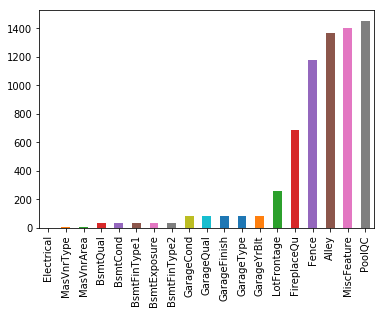

In [7]:
_NullColums = _Analysis_trainDF[_EmptyColList].isna().sum()
_NullColums.sort_values().plot.bar()

As Shown in Above Graph we can see few columns are having more than 80% Nan values
We can remove features which are containing more than 80% NaN Values from Dataframes.

In [8]:
Train_DF.drop(_EmptyColwithNAN,axis=1,inplace=True)
Train_DF.reset_index(drop=True, inplace=True)
Train_DF["SalePrice"] = np.log1p(Train_DF["SalePrice"])

Below we can plot graphs in order to find out outliers

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0b965f1ac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0b965d95c0>)

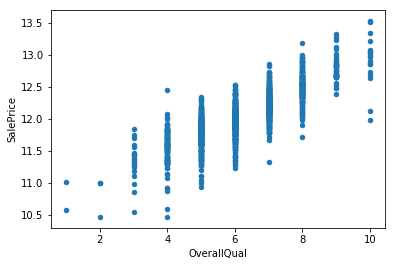

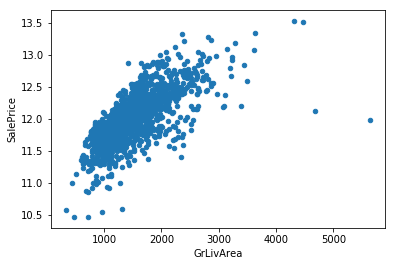

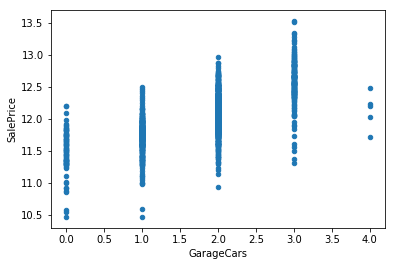

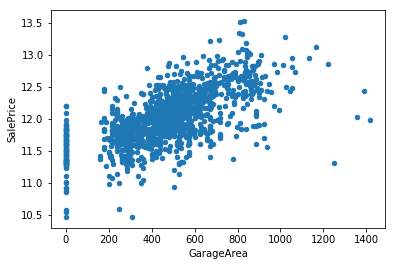

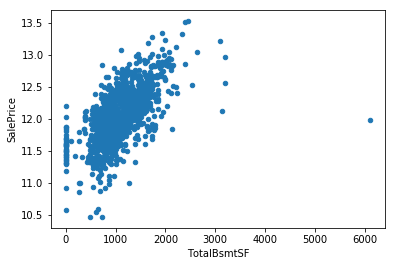

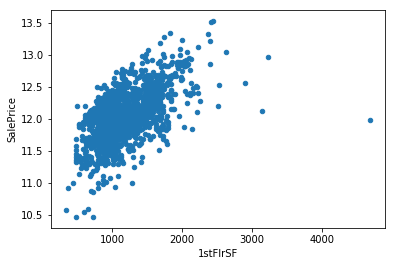

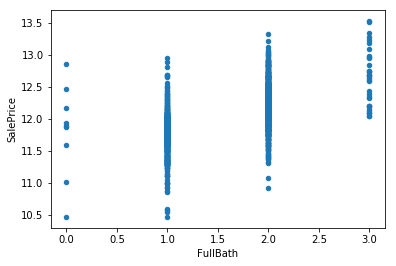

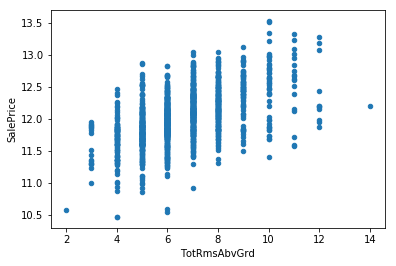

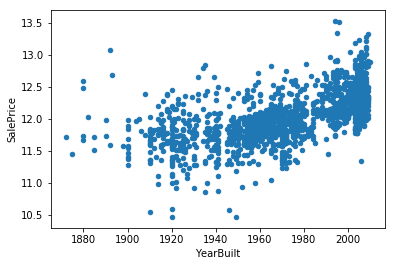

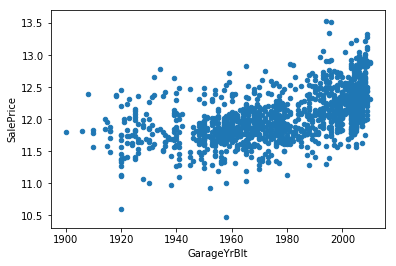

In [9]:
_Analysis_trainDF.plot.scatter(x='OverallQual',y='SalePrice'),_Analysis_trainDF.plot.scatter(x='GrLivArea',y='SalePrice')
_Analysis_trainDF.plot.scatter(x='GarageCars',y='SalePrice'),_Analysis_trainDF.plot.scatter(x='GarageArea',y='SalePrice')
_Analysis_trainDF.plot.scatter(x='TotalBsmtSF',y='SalePrice'),_Analysis_trainDF.plot.scatter(x='1stFlrSF',y='SalePrice')
_Analysis_trainDF.plot.scatter(x='FullBath',y='SalePrice'),_Analysis_trainDF.plot.scatter(x='TotRmsAbvGrd',y='SalePrice')
_Analysis_trainDF.plot.scatter(x='YearBuilt',y='SalePrice'),_Analysis_trainDF.plot.scatter(x='GarageYrBlt',y='SalePrice'),

In [10]:
# Removing outliers
Train_DF = Train_DF[(Train_DF['GrLivArea'] < 4500) & (Train_DF['LotArea'] < 50000) & (Train_DF['GarageArea'] < 1220) & (Train_DF['TotalBsmtSF'] < 3000) & (Train_DF['1stFlrSF'] < 4000) & (Train_DF['TotRmsAbvGrd'] < 13) & (Train_DF['YearBuilt'] > 1895)]  
Train_DF.reset_index(drop=True, inplace=True)
Train_DF.shape

(1426, 76)

In [11]:
y = Train_DF['SalePrice'].reset_index(drop=True)
y.shape

(1426,)

In [12]:
Train_Features = Train_DF.drop(['SalePrice'],axis = 1)
Test_Features = Test_DF
Combined_FeaturesDF = pd.concat([Train_Features, Test_Features]).reset_index(drop=True)
Train_Features.shape, Test_Features.shape, Combined_FeaturesDF.shape

((1426, 75), (1459, 79), (2885, 79))

**Feature Analysis/Engineering **

In [13]:
# 2nd floor surface area should be 0 incase of 1 story building
Combined_FeaturesDF[(Combined_FeaturesDF['HouseStyle'] == '1Story') & (Combined_FeaturesDF['2ndFlrSF'] > 0)]['2ndFlrSF'] = 0

# filling below features with most frequent Attribure/values
Combined_FeaturesDF['Electrical'].fillna(Combined_FeaturesDF['Electrical'].mode()[0],inplace=True)
Combined_FeaturesDF['Exterior1st'].fillna(Combined_FeaturesDF['Exterior1st'].mode()[0],inplace=True)
Combined_FeaturesDF['Exterior2nd'].fillna(Combined_FeaturesDF['Exterior2nd'].mode()[0],inplace=True)
Combined_FeaturesDF['Functional'].fillna(Combined_FeaturesDF['Functional'].mode()[0],inplace=True)
Combined_FeaturesDF['KitchenQual'].fillna(Combined_FeaturesDF['KitchenQual'].mode()[0],inplace=True)
Combined_FeaturesDF['MasVnrType'].fillna(Combined_FeaturesDF['MasVnrType'].mode()[0],inplace=True)
Combined_FeaturesDF['SaleType'].fillna(Combined_FeaturesDF['SaleType'].mode()[0],inplace=True)
Combined_FeaturesDF['Utilities'].fillna(Combined_FeaturesDF['Utilities'].mode()[0],inplace=True)
Combined_FeaturesDF['BsmtExposure'].fillna(Combined_FeaturesDF['BsmtExposure'].mode()[0],inplace=True)
Combined_FeaturesDF['FireplaceQu'].fillna(0,inplace=True)

#Idea is that similar MSSubClasses will have similar MSZoning
Combined_FeaturesDF['MSZoning'] = Combined_FeaturesDF.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# For those which are having no Bsmt area we can fill it with None.
for col in ('BsmtCond','BsmtFinType1','BsmtFinType2','BsmtQual'):
    Combined_FeaturesDF[col] = Combined_FeaturesDF[col].fillna('None')
# For those which are having no garage area we can fill it with None then we will encode it with some value
for col in ('GarageCond','GarageFinish','GarageQual','GarageType'):
    Combined_FeaturesDF[col] = Combined_FeaturesDF[col].fillna('None')

In [14]:
Combined_FeaturesDF['LotFrontage'] = Combined_FeaturesDF.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#below we are setting numeric features having Nan to 0
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in Combined_FeaturesDF.columns:
    if Combined_FeaturesDF[i].dtype in numeric_dtypes:
        numerics.append(i)
Combined_FeaturesDF.update(Combined_FeaturesDF[numerics].fillna(0))
numerics[1:100]

['2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

In [15]:
# Adding new features.
Combined_FeaturesDF['YrBltAndRemod']=Combined_FeaturesDF['YearBuilt']+Combined_FeaturesDF['YearRemodAdd']
Combined_FeaturesDF['TotalSF']=Combined_FeaturesDF['TotalBsmtSF'] + Combined_FeaturesDF['1stFlrSF'] + Combined_FeaturesDF['2ndFlrSF']

Combined_FeaturesDF['Total_sqr_footage'] = (Combined_FeaturesDF['BsmtFinSF1'] + Combined_FeaturesDF['BsmtFinSF2'] +
                                 Combined_FeaturesDF['1stFlrSF'] + Combined_FeaturesDF['2ndFlrSF'])

Combined_FeaturesDF['Total_Bathrooms'] = (Combined_FeaturesDF['FullBath'] + (0.5 * Combined_FeaturesDF['HalfBath']) +
                               Combined_FeaturesDF['BsmtFullBath'] + (0.5 * Combined_FeaturesDF['BsmtHalfBath']))

Combined_FeaturesDF['Total_porch_sf'] = (Combined_FeaturesDF['OpenPorchSF'] + Combined_FeaturesDF['3SsnPorch'] +
                              Combined_FeaturesDF['EnclosedPorch'] + Combined_FeaturesDF['ScreenPorch'] +
                              Combined_FeaturesDF['WoodDeckSF'])

In [16]:
#Adding few more features.
Combined_FeaturesDF['haspool'] = Combined_FeaturesDF['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
Combined_FeaturesDF['has2ndfloor'] = Combined_FeaturesDF['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
Combined_FeaturesDF['hasgarage'] = Combined_FeaturesDF['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
Combined_FeaturesDF['hasbsmt'] = Combined_FeaturesDF['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
Combined_FeaturesDF['hasfireplace'] = Combined_FeaturesDF['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
 ### Fill the remaining columns as **None**
objects = []
for i in Combined_FeaturesDF.columns:
    if Combined_FeaturesDF[i].dtype == object:
        objects.append(i)
Combined_FeaturesDF.update(Combined_FeaturesDF[objects].fillna('None'))
print(objects)

['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


Below we are doing normalization on skewed numerical features. This has a very good impact on performance of model

In [18]:
#Removing Skewness of numeric columns in dataset
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in Combined_FeaturesDF.columns:
    if Combined_FeaturesDF[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = Combined_FeaturesDF[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    Combined_FeaturesDF[i] = boxcox1p(Combined_FeaturesDF[i], boxcox_normmax(Combined_FeaturesDF[i] + 1))

In [19]:
# We are putting categorical features in list.

cols = Combined_FeaturesDF.columns
num_cols = Combined_FeaturesDF._get_numeric_data().columns
num_cols

_ListOf_Cat_column = list(set(cols) - set(num_cols))
_ListOf_Cat_column


['PoolQC',
 'ExterQual',
 'Condition2',
 'LotShape',
 'KitchenQual',
 'GarageFinish',
 'MiscFeature',
 'MSZoning',
 'SaleType',
 'BsmtFinType1',
 'BsmtQual',
 'Alley',
 'Heating',
 'Functional',
 'HouseStyle',
 'RoofMatl',
 'Exterior2nd',
 'BsmtCond',
 'SaleCondition',
 'HeatingQC',
 'Utilities',
 'ExterCond',
 'LotConfig',
 'RoofStyle',
 'MasVnrType',
 'FireplaceQu',
 'GarageCond',
 'Neighborhood',
 'BsmtExposure',
 'LandContour',
 'Foundation',
 'GarageQual',
 'BsmtFinType2',
 'Condition1',
 'PavedDrive',
 'Electrical',
 'Fence',
 'CentralAir',
 'GarageType',
 'LandSlope',
 'BldgType',
 'Street',
 'Exterior1st']

In [20]:
#Comment out for now , let see what is the when we are trying using get_dummies
'''le = preprocessing.LabelEncoder()
# apply le on categorical feature columns
Combined_FeaturesDF[_ListOf_Cat_column] = Combined_FeaturesDF[_ListOf_Cat_column].apply(lambda col: le.fit_transform(col))
Combined_FeaturesDF.head(10)'''

# One Hot Encoding for categorical features
final_features = pd.get_dummies(Combined_FeaturesDF).reset_index(drop=True)
final_features.shape

(2885, 308)

In [21]:
final_features.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,...,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Gd,PoolQC_None,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.020400,1087.757926,0.0,3,145.140095,0.0,0.995113,0.000000,30.044394,0.000000,0.000000,2,548.0,2.0,2003.0,8.790843,1.068467,0.751543,55.956514,18.283461,0.0,6.554199,19.444493,0.0,2,12.169342,4.089335,7,0.0,0.0,2.337127,470.952807,0.000000,2003,2003,2008,4006,38.734548,12.274737,3.5,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0
1,6.325127,0.000000,0.0,3,183.086279,0.0,0.000000,0.711048,44.226358,0.000000,0.902604,2,460.0,2.0,1976.0,8.373988,0.000000,0.751543,58.474585,20.841456,0.0,4.275228,0.000000,0.0,5,0.000000,6.188031,6,0.0,0.0,2.055120,666.919490,58.072084,1976,1976,2007,3952,38.503694,12.098655,2.5,...,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,6.077303,1103.682623,0.0,3,111.170402,0.0,0.995113,0.000000,57.024693,0.000000,0.902604,2,608.0,2.0,2001.0,8.850970,1.068467,0.751543,61.754951,18.812810,0.0,6.554199,17.778739,0.0,9,9.966339,4.089335,7,0.0,0.0,2.055120,502.396500,0.000000,2001,2002,2008,4003,39.486424,12.131566,3.5,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0
3,6.111646,958.068347,0.0,3,62.138939,0.0,0.995113,0.000000,64.961325,16.096942,0.902604,1,642.0,3.0,1998.0,8.796487,0.000000,0.751543,58.369453,17.378641,0.0,6.922514,0.000000,0.0,2,9.021889,4.089335,7,0.0,0.0,2.204469,421.319417,0.000000,1915,1970,2006,3885,38.219920,11.759667,2.0,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
4,6.249125,1352.965653,0.0,4,137.580223,0.0,0.995113,0.000000,61.307549,0.000000,0.902604,2,836.0,3.0,2000.0,9.139564,1.068467,0.751543,66.987666,21.489659,0.0,6.554199,25.420962,0.0,12,14.386575,4.089335,8,0.0,0.0,2.456534,611.234000,43.530065,2000,2000,2008,4000,42.615285,12.666940,3.5,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0


Below we can see Heatmap in order to see correlation of features with respect to target variable

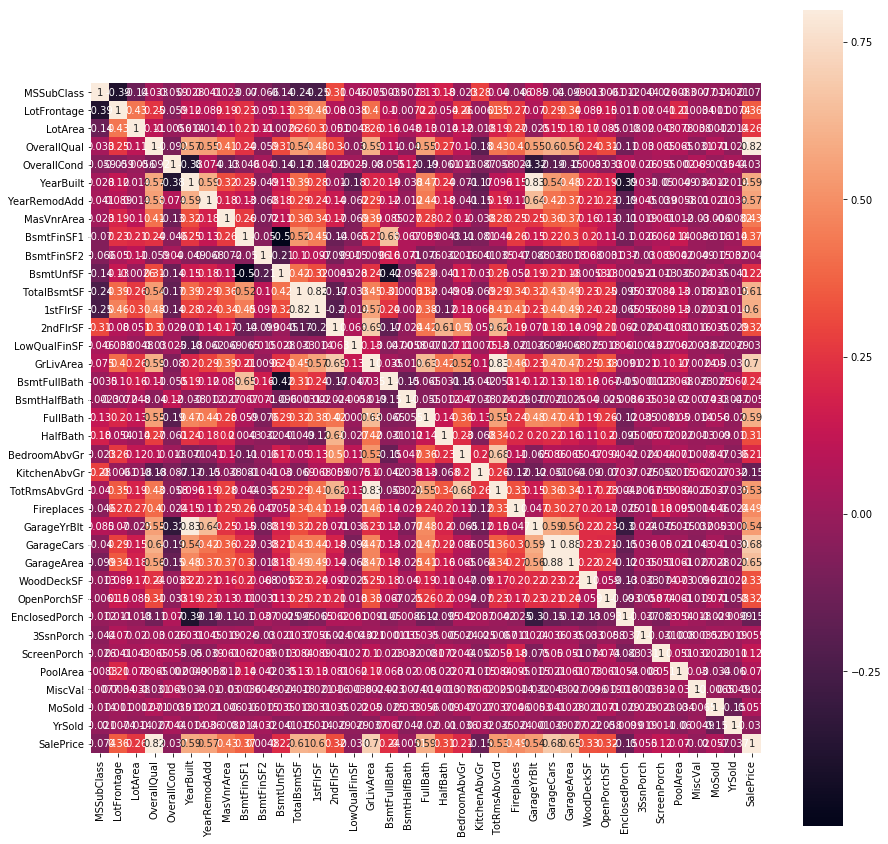

OverallQual      1.000000
SalePrice        0.817185
GarageCars       0.600671
GrLivArea        0.593007
YearBuilt        0.572323
GarageArea       0.562022
YearRemodAdd     0.550684
FullBath         0.550600
GarageYrBlt      0.547766
TotalBsmtSF      0.537808
1stFlrSF         0.476224
TotRmsAbvGrd     0.427452
MasVnrArea       0.411876
Fireplaces       0.396765
OpenPorchSF      0.308819
BsmtUnfSF        0.308159
2ndFlrSF         0.295493
HalfBath         0.273458
LotFrontage      0.251646
BsmtFinSF1       0.239666
WoodDeckSF       0.238923
BsmtFullBath     0.111098
LotArea          0.105806
BedroomAbvGr     0.101676
MoSold           0.070815
PoolArea         0.065166
ScreenPorch      0.064886
MSSubClass       0.032628
3SsnPorch        0.030371
YrSold          -0.027347
LowQualFinSF    -0.030429
MiscVal         -0.031406
BsmtHalfBath    -0.040150
BsmtFinSF2      -0.059119
OverallCond     -0.091932
EnclosedPorch   -0.113937
KitchenAbvGr    -0.183882
Name: OverallQual, dtype: float64

In [22]:
C_mat = _Analysis_trainDF.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True, annot=True)
plt.show()
C_mat.OverallQual.sort_values(ascending=False)

(SalePrice        1.000000
 OverallQual      0.817185
 GrLivArea        0.700927
 GarageCars       0.680625
 GarageArea       0.650888
 TotalBsmtSF      0.612134
 1stFlrSF         0.596981
 FullBath         0.594771
 YearBuilt        0.586570
 YearRemodAdd     0.565608
 GarageYrBlt      0.541073
 TotRmsAbvGrd     0.534422
 Fireplaces       0.489450
 MasVnrArea       0.430809
 BsmtFinSF1       0.372023
 LotFrontage      0.355879
 WoodDeckSF       0.334135
 OpenPorchSF      0.321053
 2ndFlrSF         0.319300
 HalfBath         0.313982
 LotArea          0.257320
 BsmtFullBath     0.236224
 BsmtUnfSF        0.221985
 BedroomAbvGr     0.209043
 ScreenPorch      0.121208
 PoolArea         0.069798
 MoSold           0.057330
 3SsnPorch        0.054900
 BsmtFinSF2       0.004832
 BsmtHalfBath    -0.005149
 MiscVal         -0.020021
 OverallCond     -0.036868
 YrSold          -0.037263
 LowQualFinSF    -0.037963
 MSSubClass      -0.073959
 KitchenAbvGr    -0.147548
 EnclosedPorch   -0.149050
 

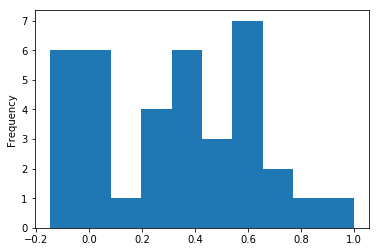

In [23]:
C_mat.SalePrice.sort_values(ascending=False),C_mat.SalePrice.sort_values(ascending=False).plot.hist()

In [24]:
# creating data for fitting model
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1426, 308), (1426,), (1459, 308))

## Using Boosting Technique ##

In [25]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as pyplot
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR

In [26]:
# defining error functions for handy use. 
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, T=X):
    rmse = np.sqrt(-cross_val_score(model, T, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [27]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [28]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                

In [29]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [30]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [31]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [32]:
score = cv_rmse(ridge)
print(score)
score = cv_rmse(lasso)
print(score)
score = cv_rmse(elasticnet)
print(score)
score = cv_rmse(gbr)
print(score)
score = cv_rmse(lightgbm)
print(score)
score = cv_rmse(xgboost)
print(score)

NameError: name 'y_train' is not defined

StackingCVRegressor- combining multiple models into a single one.
http://www.programmersought.com/article/5645254916/

In [33]:
#In order to avoid overfitting. we are using StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [34]:
#Start Fitting
print('Start fitting models')
#stack_gen.fit(X_train,y_train)
print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print('stack_gen_model',stack_gen_model)

GradiantBoosting_model = gbr.fit(X, y)
print('GradiantBoosting_model',GradiantBoosting_model)

XGBoosting_model = xgboost.fit(X, y)
print('XGBoosting_model',XGBoosting_model)

LightGBM_model = lightgbm.fit(X, y)
print('LightGBM_model',LightGBM_model)

Start fitting models
elasticnet
Lasso
Ridge
stack_gen_model StackingCVRegressor(cv=5,
          meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=0, missing=None, n_estimators=3000, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=6e-05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7),
          n_jobs=1, pre_dispatch=None, refit=True,
          regressors=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
    cv=KFold(n_splits=10, random_...bda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbose=-1)),
   

In [35]:
# Assigning different weight of models in order to create final one depending on scores of each model
def combine_models_predict(X):
    return ((0.15 * GradiantBoosting_model.predict(X)) + \
            (0.2 * XGBoosting_model.predict(X)) + \
            (0.1 * ridge.predict(X)) + \
            (0.05 * lasso.predict(X)) + \
            (0.1 * elasticnet.predict(X)) + \
            (0.1 * LightGBM_model.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [36]:
print('Predict submission')
submission = pd.read_csv("../input/sample_submission.csv")
submission['SalePrice'] = (np.expm1(combine_models_predict(X_sub)))
submission.to_csv("sample_submission.csv",index=False)

Predict submission
